In [363]:
import pandas as pd 
import numpy as np
import os
import pathlib 
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [364]:
def parseConfigData(config_string):
    # Define regular expressions for extracting data
    failures_pattern = r"Failures: (\d+\.\d+)%"
    cost_pattern = r"Experiment cost: \$([0-9.]+)"
    cpu_pattern = r"CPU: \[([\d., ]+)\]"
    mem_pattern = r"Mem: \[([\d., ]+)\]"
    func_args_pattern = r"Function argument\(s\): (.+)"

    # Initialize the dictionary to store extracted values
    config_data = {}

    # Extract and store Failures
    failures_match = re.search(failures_pattern, config_string)
    if failures_match:
        config_data["Failures"] = float(failures_match.group(1))

    # Extract and store Experiment cost
    cost_match = re.search(cost_pattern, config_string)
    if cost_match:
        config_data["Experiment Cost"] = float(cost_match.group(1))

    # Extract and store CPU values
    cpu_match = re.search(cpu_pattern, config_string)
    if cpu_match:
        config_data["CPU"] = [float(x.strip()) for x in cpu_match.group(1).split(',')]

    # Extract and store Mem values
    mem_match = re.search(mem_pattern, config_string)
    if mem_match:
        config_data["Mem"] = [float(x.strip()) for x in mem_match.group(1).split(',')]
        
    # Extract and store Function arguments
    func_args_match = re.search(func_args_pattern, config_string)
    if func_args_match:
        config_data["Function Arguments"] = func_args_match.group(1)

    return config_data

In [365]:
def sizeFromCount(count):
    return {
        19: "XL",
        14: "XL",
        10: "L",
        5: "M",
        3: "S"  
    }[count]

In [366]:
def readExp(path, n=9):
    with open(path) as file:
        head = [next(file) for _ in range(n)]
        df = pd.read_csv(file)
        
    res = parseConfigData("\n".join(head))
    best = df.iloc[0]
    
    res['funcName'] = str(path).split("_")[1]
    res['bestCost'] = best.cost
    res['bestTime'] = best.time
    res['bestTimeAndCost'] = best.timeAndCost
    res['runSize'] = sizeFromCount(len(res['CPU']))
    res['best'] = best
    res['df'] = df
    return res

In [367]:
resultsPath = "../FaaSterConfig/results/"

In [379]:
results = [x for x in sorted(pathlib.Path(resultsPath).iterdir(), key=os.path.getmtime)]
for path in results:
    print(os.path.basename(path))

FaaSterResults_matmul2_20231119-122643.csv
FaaSterResults_image-processing_20231119-184711.csv
FaaSterResults_matmul2_20231119-160223.csv
FaaSterResults_image-processing_20231119-200655.csv
FaaSterResults_matmul2_20231119-193345.csv
FaaSterResults_matmul2_20231119-211914.csv
FaaSterResults_openfaas-ocr_20231119-214216.csv
FaaSterResults_s3du_20231119-215250.csv
FaaSterResults_openfaas-ocr_20231119-215708.csv
FaaSterResults_s3du_20231119-220249.csv
FaaSterResults_matmul2_20231119-192853.csv
FaaSterResults_matmul2_20231119-194514.csv
FaaSterResults_matmul2_20231119-194945.csv
FaaSterResults_matmul2_20231119-200224.csv


In [380]:
exps = [readExp(r) for r in results]

In [381]:
exps

[{'Failures': 11.11,
  'Experiment Cost': 0.18050395647511114,
  'CPU': [0.25, 0.5, 1.0],
  'Mem': [248.0, 500.0, 15000.0],
  'Function Arguments': '1000',
  'funcName': 'matmul2',
  'bestCost': 4.732051067776151e-06,
  'bestTime': 0.515482,
  'bestTimeAndCost': -0.9106897192503464,
  'runSize': 'S',
  'best': CPU                 1.0
  Mem               500.0
  NodeTypeStr    c5.large
  time           0.515482
  cost           0.000005
  costPerHour    0.033047
  startupTime    4.502557
  timeAndCost    -0.91069
  Name: 0, dtype: object,
  'df':      CPU      Mem NodeTypeStr      time      cost  costPerHour  startupTime  \
  0   1.00    500.0    c5.large  0.515482  0.000005     0.033047     4.502557   
  1   1.00    248.0    m5.large  0.544234  0.000005     0.031816     3.364532   
  2   1.00    500.0   c7g.large  0.604672  0.000005     0.028110     2.290338   
  3   1.00    248.0    c5.large  0.606817  0.000005     0.029779     3.411319   
  4   1.00    248.0   c7g.large  0.624784  0.

In [382]:
exps[0].keys()

dict_keys(['Failures', 'Experiment Cost', 'CPU', 'Mem', 'Function Arguments', 'funcName', 'bestCost', 'bestTime', 'bestTimeAndCost', 'runSize', 'best', 'df'])

In [383]:
desired_keys = ['Failures', 'Experiment Cost', 'funcName', 'bestCost', 'bestTime','runSize', 'bestTimeAndCost','Function Arguments']

# Create a DataFrame with the desired subset of keys
df = pd.DataFrame([{key: d[key] for key in desired_keys} for d in exps])


In [395]:
matmuldf = df[df['funcName'] == 'matmul2'].sort_values(by=['funcName','Function Arguments','runSize'], ascending=False)
matmuldf['short_func_args'] = matmuldf['Function Arguments'].apply(lambda x: f"{int(int(x) / 1000)}k" if int(x) >= 1000 else str(x))
matmuldf

,Failures,Experiment Cost,funcName,bestCost,bestTime,runSize,bestTimeAndCost,Function Arguments,short_func_args
12,70.83,0.147979,matmul2,0.000090,5.052456,S,-1.183435,5000,5k
13,58.75,0.366687,matmul2,0.000096,5.720743,M,-1.030330,5000,5k
2,19.15,1.671149,matmul2,0.000004,0.520609,XL,-1.102812,1000,1k
0,11.11,0.180504,matmul2,0.000005,0.515482,S,-0.910690,1000,1k
11,16.25,0.218352,matmul2,0.000004,0.577439,M,-0.723853,1000,1k
10,37.50,0.139170,matmul2,0.000004,0.573503,S,-0.825610,10,10
4,13.75,0.157046,matmul2,0.000004,0.481963,M,-0.676435,10,10
5,43.75,1.504541,matmul2,0.000004,0.487339,L,-0.683070,10,10


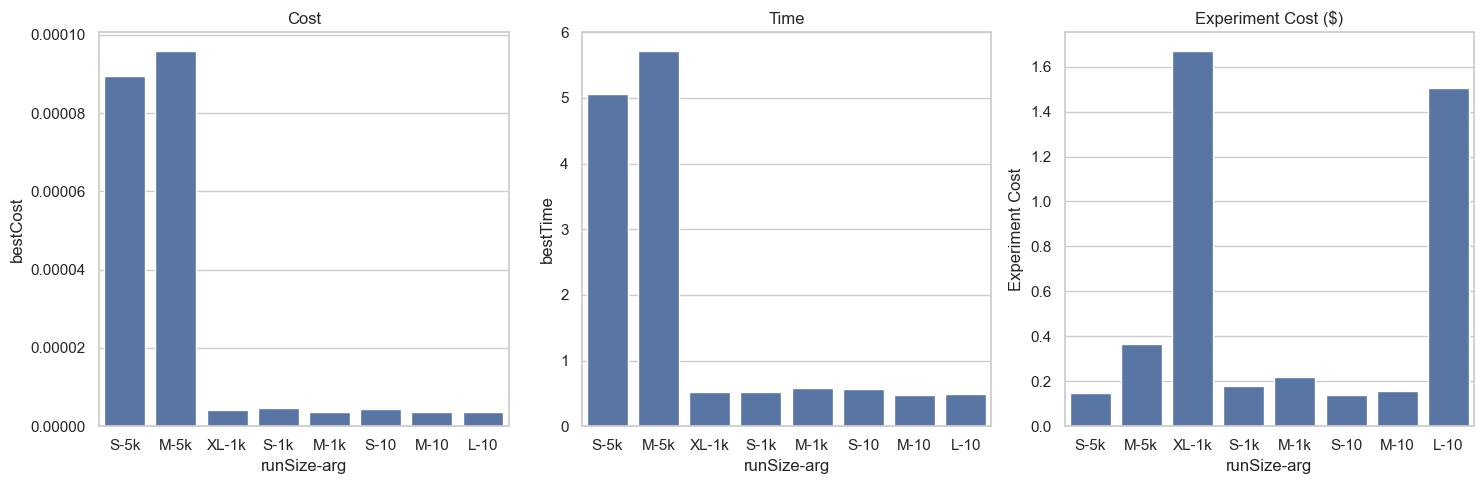

In [414]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

matmuldf['runSize-arg'] = matmuldf['runSize'] + '-' + matmuldf['short_func_args']

# Create a figure with three subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Bar chart for bestCost
sns.barplot(x="runSize-arg", y="bestCost", data=matmuldf, ax=axes[0])
axes[0].set_title("Cost")

# Bar chart for bestTime
sns.barplot(x="runSize-arg", y="bestTime", data=matmuldf, ax=axes[1])
axes[1].set_title("Time")

# Bar chart for Experiment Cost
sns.barplot(x="runSize-arg", y="Experiment Cost", data=matmuldf, ax=axes[2])
axes[2].set_title("Experiment Cost ($)")

# Adjust layout
plt.tight_layout()
# plt.show()
plt.savefig('../results/matmul-cost-bar-charts.png')

In [408]:
others = df[df['funcName'] != 'matmul2'].sort_values(by=['funcName','runSize'], ascending=False)
# matmuldf['short_func_args'] = matmuldf['Function Arguments'].apply(lambda x: f"{int(int(x) / 1000)}k" if int(x) >= 1000 else str(x))
others['function'] = others['funcName']
others

,Failures,Experiment Cost,funcName,bestCost,bestTime,runSize,bestTimeAndCost,Function Arguments,function
9,45.83,0.178700,s3du,0.000032,2.832040,S,-1.283575,"{""input_bucket"": ""inputbucketbenchmark"",""objec...",s3du
7,25.00,0.310363,s3du,0.000026,2.916793,M,-1.121456,"{""input_bucket"": ""inputbucketbenchmark"",""objec...",s3du
8,41.67,0.141785,openfaas-ocr,0.000015,1.084709,S,-0.992812,https://www.pyimagesearch.com/wp-content/uploa...,openfaas-ocr
6,23.75,0.162271,openfaas-ocr,0.000008,1.305634,M,-1.212920,https://www.pyimagesearch.com/wp-content/uploa...,openfaas-ocr
3,41.67,0.147780,image-processing,0.000006,0.920406,S,-0.657728,https://raw.githubusercontent.com/MBtech/rethi...,image-processing
1,3.75,0.145143,image-processing,0.000006,0.936691,M,-0.663791,https://raw.githubusercontent.com/MBtech/rethi...,image-processing


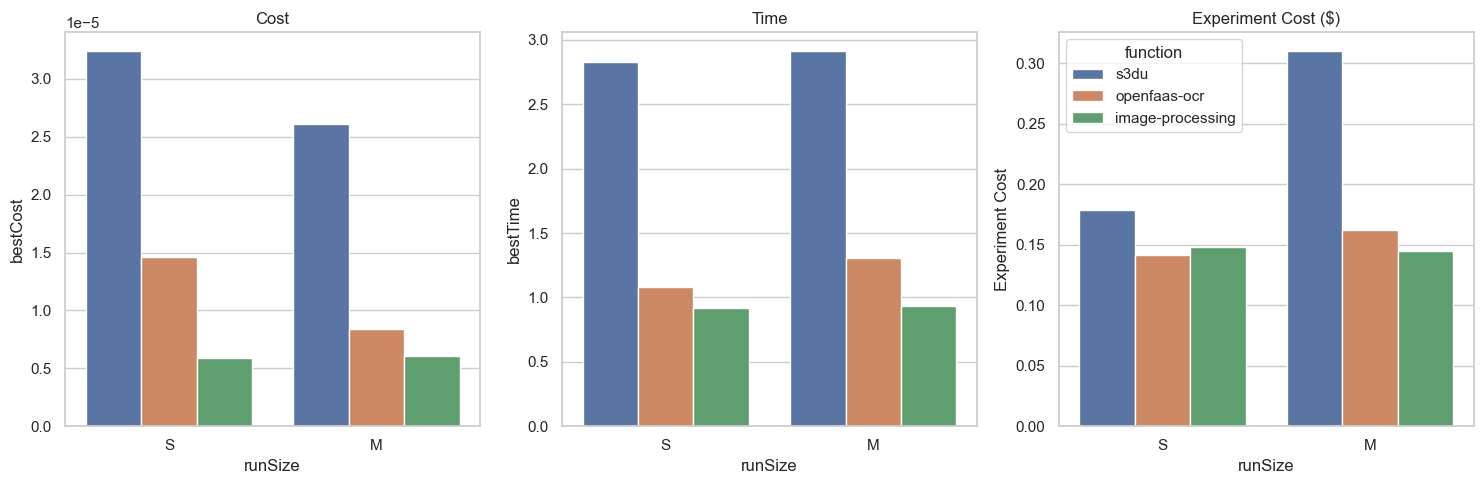

In [413]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

others['function-runSize'] = others['function'] + '-' + others['runSize']

# Create a figure with three subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Bar chart for bestCost
sns.barplot(x='runSize', y="bestCost", hue="function", data=others, ax=axes[0])
axes[0].set_title("Cost")
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
axes[0].legend().set_visible(False)  # Hide legend for the second chart

# Bar chart for bestTime
sns.barplot(x='runSize', y="bestTime", hue="function",data=others, ax=axes[1])
axes[1].set_title("Time")
axes[1].legend().set_visible(False)  # Hide legend for the second chart


# Bar chart for Experiment Cost
sns.barplot(x='runSize', y="Experiment Cost",hue="function", data=others, ax=axes[2],legend=(axes[2] == axes[2]))
axes[2].set_title("Experiment Cost ($)")

# Adjust layout
plt.tight_layout()
# plt.show()
plt.savefig('../results/others-cost-bar-charts.png')

In [436]:
# exp = exps[-1]
exp = next(filter(lambda x: x['funcName'] == 'matmul2' and x['runSize'] == 'XL' and x['Function Arguments'] == '1000', exps))
exp

{'Failures': 19.15,
 'Experiment Cost': 1.6711491033423331,
 'CPU': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
 'Mem': [256.0,
  384.0,
  512.0,
  640.0,
  768.0,
  896.0,
  1024.0,
  1152.0,
  1280.0,
  1408.0,
  1536.0,
  1664.0,
  1792.0,
  1920.0,
  2048.0,
  2176.0,
  2304.0,
  2432.0],
 'Function Arguments': '1000',
 'funcName': 'matmul2',
 'bestCost': 4.206730939553669e-06,
 'bestTime': 0.520609,
 'bestTimeAndCost': -1.102812312060801,
 'runSize': 'XL',
 'best': CPU                  1.1
 Mem                384.0
 NodeTypeStr    c7g.large
 time            0.520609
 cost            0.000004
 costPerHour     0.029089
 startupTime     4.712522
 timeAndCost    -1.102812
 Name: 0, dtype: object,
 'df':       CPU     Mem NodeTypeStr      time      cost  costPerHour  startupTime  \
 0     1.1   384.0   c7g.large  0.520609  0.000004     0.029089     4.712522   
 1     1.3   640.0   c7g.large  0.471884  0.000005     0.036432     4.772755   
 2     0.9   384.0 

In [437]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

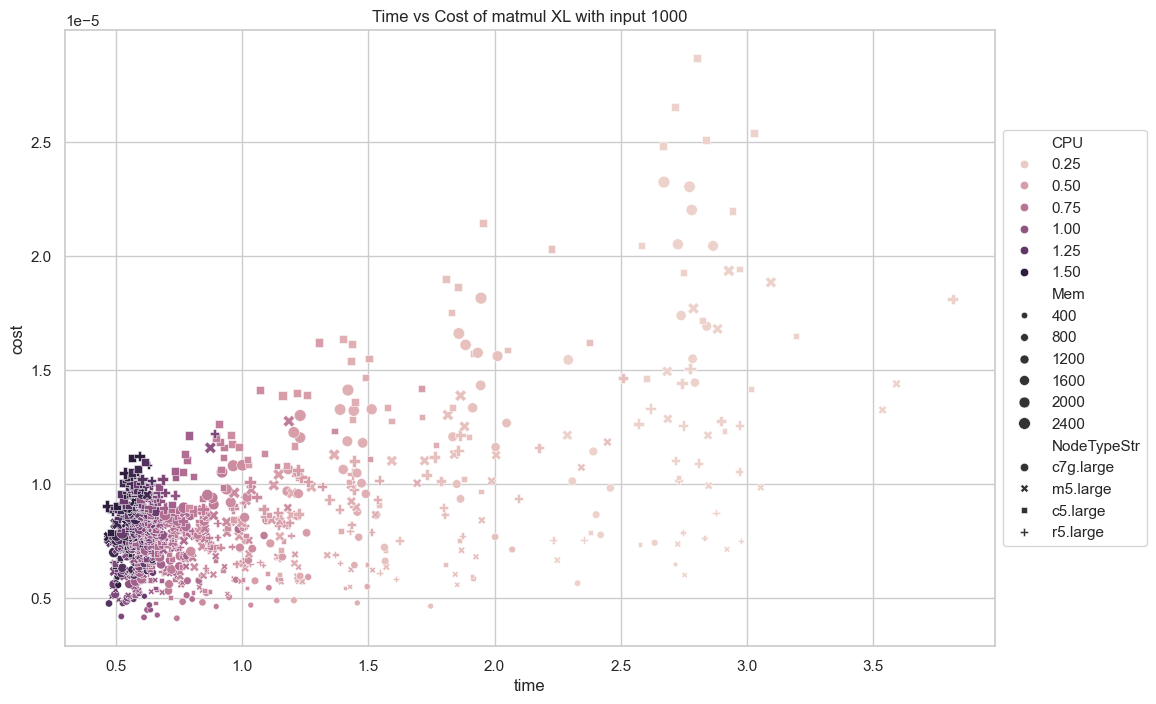

In [438]:
# Plot 1: time vs cost, colored by CPU, size of Mem, and shape of NodeType
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x="time", y="cost", hue="CPU", size="Mem", style="NodeTypeStr", data=exp['df'])
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
scatter.set_title(f"Time vs Cost of matmul {exp['runSize']} with input {exp['Function Arguments']}")
# plt.show()
plt.savefig('../results/matmul-X-1000.png')

In [432]:
# exp = exps[-1]
exp = next(filter(lambda x: x['funcName'] == 'matmul2' and x['runSize'] == 'S' and x['Function Arguments'] == '1000', exps))
exp

{'Failures': 11.11,
 'Experiment Cost': 0.18050395647511114,
 'CPU': [0.25, 0.5, 1.0],
 'Mem': [248.0, 500.0, 15000.0],
 'Function Arguments': '1000',
 'funcName': 'matmul2',
 'bestCost': 4.732051067776151e-06,
 'bestTime': 0.515482,
 'bestTimeAndCost': -0.9106897192503464,
 'runSize': 'S',
 'best': CPU                 1.0
 Mem               500.0
 NodeTypeStr    c5.large
 time           0.515482
 cost           0.000005
 costPerHour    0.033047
 startupTime    4.502557
 timeAndCost    -0.91069
 Name: 0, dtype: object,
 'df':      CPU      Mem NodeTypeStr      time      cost  costPerHour  startupTime  \
 0   1.00    500.0    c5.large  0.515482  0.000005     0.033047     4.502557   
 1   1.00    248.0    m5.large  0.544234  0.000005     0.031816     3.364532   
 2   1.00    500.0   c7g.large  0.604672  0.000005     0.028110     2.290338   
 3   1.00    248.0    c5.large  0.606817  0.000005     0.029779     3.411319   
 4   1.00    248.0   c7g.large  0.624784  0.000004     0.025330     3

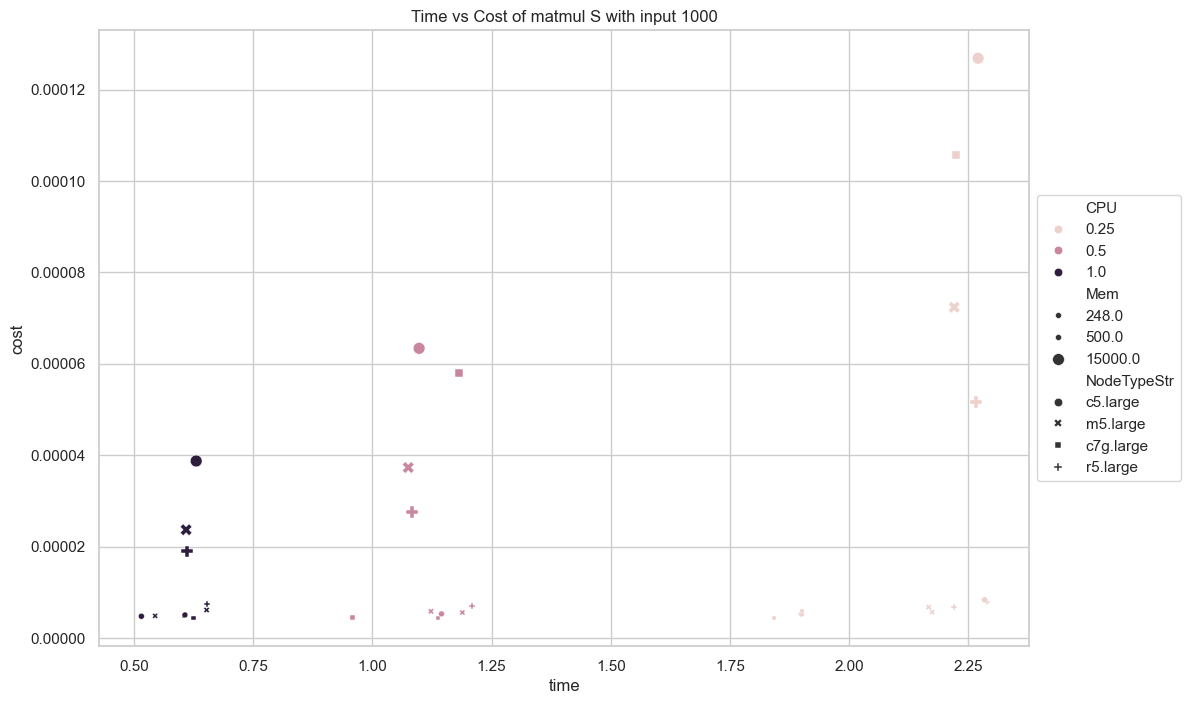

In [433]:
# Plot 1: time vs cost, colored by CPU, size of Mem, and shape of NodeType
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x="time", y="cost", hue="CPU", size="Mem", style="NodeTypeStr", data=exp['df'])
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
scatter.set_title(f"Time vs Cost of matmul {exp['runSize']} with input {exp['Function Arguments']}")
# plt.show()
plt.savefig('../results/matmul-XL-1000.png')

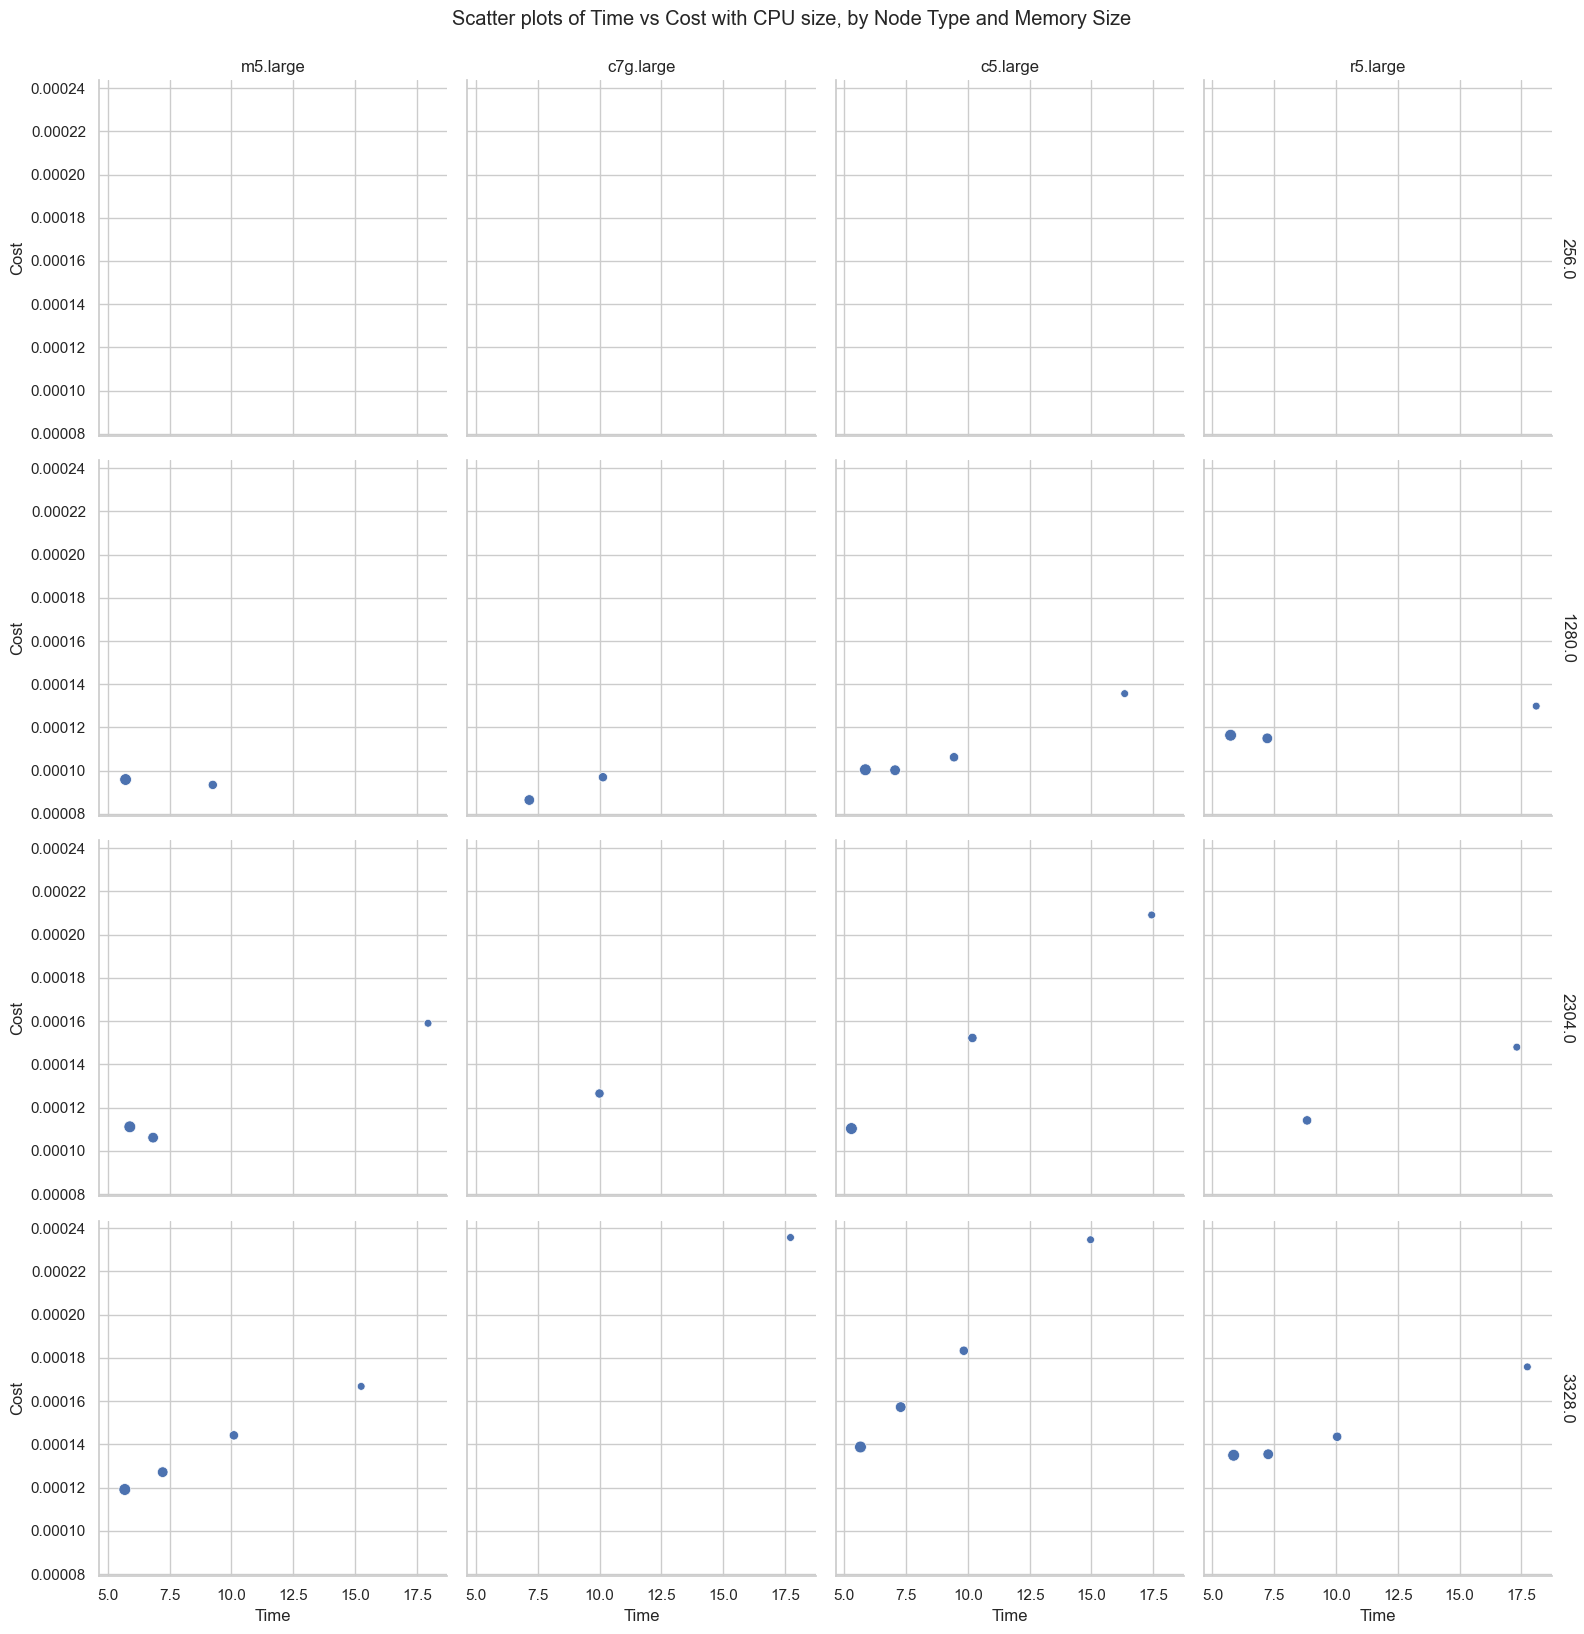

In [152]:
# Create a FacetGrid with node type on the x-axis and memory size on the y-axis
g = sns.FacetGrid(df, col="NodeTypeStr", row="Mem", margin_titles=True, height=4)

# Map scatter plots to each subplot
g.map(sns.scatterplot, "time", "cost", size="CPU", data=df)

# Adjust layout and add titles
g.set_axis_labels("Time", "Cost")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Scatter plots of Time vs Cost with CPU size, by Node Type and Memory Size", y=1.02)

# Show the plot
plt.show()

In [122]:
def getRanges(start, end, num=10):
    step = (end-start)/num
    return np.arange(start, end, step)

def subSample(arr, rate=1):
    return arr[0::rate]

def npstr(arr):
    return ' '.join([f"{v:.5}" for v in arr])

In [123]:
allCpu = np.arange(.1,2,.1)
allMem = np.arange(.25,4,.25)*1024
allCpu,allMem, len(allCpu), len(allMem)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 array([ 256.,  512.,  768., 1024., 1280., 1536., 1792., 2048., 2304.,
        2560., 2816., 3072., 3328., 3584., 3840.]),
 19,
 15)

In [136]:
cpu = subSample(allCpu, 8)
cpu

array([0.1, 0.9, 1.7])

In [94]:
mem = getRanges(2**8, 2**10, 5)
mem

array([256. , 409.6, 563.2, 716.8, 870.4])

In [137]:
def getCommand(cpu, mem):
    return f"-c {npstr(cpu)} -m {npstr(mem)}"

In [140]:
def getCommands():
    for s in [1,2,4,8]:
        cpu = subSample(allCpu, s)
        mem = subSample(allMem, s)
        print(len(cpu),len(mem))
        yield getCommand(cpu,mem)

In [141]:
list(getCommands())

19 15
10 8
5 4
3 2


['-c 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 -m 256.0 512.0 768.0 1024.0 1280.0 1536.0 1792.0 2048.0 2304.0 2560.0 2816.0 3072.0 3328.0 3584.0 3840.0',
 '-c 0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 -m 256.0 768.0 1280.0 1792.0 2304.0 2816.0 3328.0 3840.0',
 '-c 0.1 0.5 0.9 1.3 1.7 -m 256.0 1280.0 2304.0 3328.0',
 '-c 0.1 0.9 1.7 -m 256.0 2304.0']